<a href="https://colab.research.google.com/github/str1der1/SirajRavalCourse_wk4_Homework_TransferLearning_MEdical_images_using_InceptionV3/blob/master/wk4_Homework_TransferLearning_MedicalImages_Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Start of Wk 4  Homework

For practising Transfer Learnign from an existing Keras application to work with decoding images


Based on Kaggle competition:     https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# Upload the Kaggle json key for my account

# from google.colab import files
# files.upload()

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:44<00:00, 42.0MB/s]
100% 2.29G/2.29G [00:44<00:00, 55.8MB/s]


In [0]:
# !pip3 install -q kaggle

In [0]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [0]:
# This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

In [0]:
# List available datasets.
# !kaggle datasets list

In [0]:
# Copy the kaggle Dataset  set locally.
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
# !sudo apt-get install unzip

In [0]:
!unzip  -q ./chest-xray-pneumonia.zip
# !unzip ./chest-xray-pneumonia.zip

In [11]:
!ls -al 

total 2405656
drwxr-xr-x 1 root root       4096 Oct  6 21:03 .
drwxr-xr-x 1 root root       4096 Oct  6 21:00 ..
drwxr-xr-x 7 root root       4096 Oct  6 21:03 chest_xray
-rw-r--r-- 1 root root 2463365435 Oct  6 21:03 chest-xray-pneumonia.zip
drwxr-xr-x 1 root root       4096 Sep 27 15:12 .config
drwxr-xr-x 1 root root       4096 Aug 27 16:17 sample_data


In [0]:
# !unzip ./chest_xray.zip

In [0]:
import os
import shutil
import glob
import urllib.request

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 


Read the data in using directory regular expressions

In [14]:
glob.glob('./chest_xray/*/*')

['./chest_xray/chest_xray/test',
 './chest_xray/chest_xray/val',
 './chest_xray/chest_xray/train',
 './chest_xray/test/PNEUMONIA',
 './chest_xray/test/NORMAL',
 './chest_xray/val/PNEUMONIA',
 './chest_xray/val/NORMAL',
 './chest_xray/train/PNEUMONIA',
 './chest_xray/train/NORMAL',
 './chest_xray/__MACOSX/chest_xray']

## Load some images for Fun !

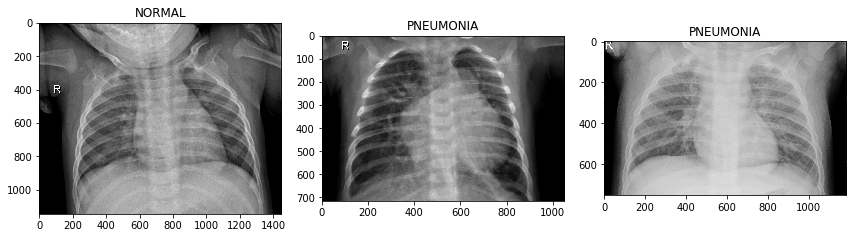

In [15]:
img_normal = plt.imread('./chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('./chest_xray/train/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread('./chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

## We have to bring in all the files into a data repository

In [0]:
def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

Now run this 

In [0]:
x, y = get_labeled_files('./chest_xray/train/')

In [18]:
list(zip(x, y))[:10]

[('./chest_xray/train/PNEUMONIA/person67_bacteria_332.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person419_virus_861.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person515_bacteria_2189.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person1471_bacteria_3831.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person1082_virus_1794.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person922_bacteria_2847.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person23_bacteria_84.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person600_bacteria_2456.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg', 1),
 ('./chest_xray/train/PNEUMONIA/person1746_bacteria_4585.jpeg', 1)]

## Function to 
1) PArse the image 
2) resize the image

In [0]:
NUM_CLASSES = 2

# This function takes image paths as arguments and reads corresponding images
def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)
    # read the img from file and decode it using tf
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_file, channels=3, name="decoded_images")
    return img_decoded, one_hot

# This function takes image and resizes it to smaller format (150x150)
def image_resize(images, labels):
    # Be very careful with resizing images like this and make sure to read the doc!
    # Otherwise, bad things can happen - https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
    resized_image = tf.image.resize_images(images, (150, 150), align_corners=True)
    # AA  resized_image_asint = tf.cast(resized_image, tf.int32)
    resized_image_asflt = tf.cast(resized_image, tf.float32)
    # AA  return resized_image_asint, labels    
    return resized_image_asflt, labels    

# AA: This function takes image and normalizes it from 0->1
def image_normalize(images, labels):
    # print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # convert from integers to floats
    # images = images.astype('float32')
    # normalize to the range 0-1
    images /= 255.0
    # confirm the normalization
    # print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    return images, labels    



## Create pipeline functions to move images to tensors.

first functions 1)     Manages the task of movingthrough images
Seond function:  2)   Enable executing this as part of a tensorflow session

In [0]:


# Execution plan is defined here.
# Since it uses lazy evaluation, the images will not be read after calling build_pipeline_plan()
# We need to use iterator defined here in tf context
def build_pipeline_plan(img_paths, labels, batch_size):

    # We build a tensor of image paths and labels
    tr_data = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    # First step of input pipeline - read images in paths as jpegs
    tr_data_imgs = tr_data.map(input_parser)
    # Apply resize to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_resize)
    # AA:  Apply normailze to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_normalize)
    # Gives us opportuinty to batch images into small groups
    tr_dataset = tr_data_imgs.batch(batch_size)
    # create TensorFlow Iterator object directly from input pipeline
    iterator = tr_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element

# Function to execute defined pipeline in Tensorflow session
def process_pipeline(next_element):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # get each element of the training dataset until the end is reached
        # in our case only one iteration since we read everything as 1 batch
        # can be multiple iterations if we decrease BATCH_SIZE to eg. 10
        images = []
        labels_hot = []
        while True:
            try:
                elem = sess.run(next_element)
                images = elem[0]
                labels_hot = elem[1]
            except tf.errors.OutOfRangeError:
                print("Finished reading the dataset")
                return images, labels_hot



Load the dataset and return it into images and labels.

In [0]:
def load_dataset(path, batch_size):
    tf.reset_default_graph()
    files, labels = get_labeled_files(path)
    p = tf.constant(files, name="train_imgs")
    l = tf.constant(labels, name="train_labels")
    
    next_element = build_pipeline_plan(p, l, batch_size=batch_size)
    imgs, labels = process_pipeline(next_element)
    return imgs, labels

Lets check what we have done.

In [22]:
x_train, y_train = load_dataset("./chest_xray/train/", 6000)
x_val, y_val = load_dataset("./chest_xray/val/", 6000)
x_test, y_test = load_dataset("./chest_xray/test/", 6000)


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Finished reading the dataset
Finished reading the dataset
Finished reading the dataset


In [23]:
print("Training Dataset")
print(x_train.shape)
print(y_train.shape)
print("\nTesting Dataset")
print(x_test.shape)
print(y_test.shape)
print("\n Validation  Dataset")
print(x_val.shape)
print(y_val.shape)

Training Dataset
(5216, 150, 150, 3)
(5216, 2)

Testing Dataset
(624, 150, 150, 3)
(624, 2)

 Validation  Dataset
(16, 150, 150, 3)
(16, 2)


In [0]:
# print(x_train[1,:,:,1])
# fullprint(y_train)

## Calculate a visualisation

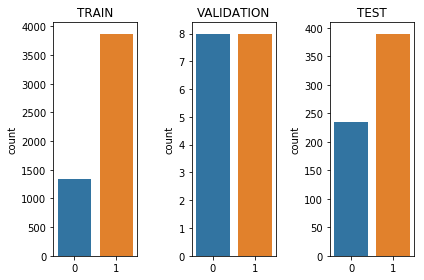

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.subplot(1,3,1)
sns.countplot(np.argmax(y_train, axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(y_val, axis=1)).set_title('VALIDATION')

plt.subplot(1,3,3)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.tight_layout()

(5216, 150, 150, 3)


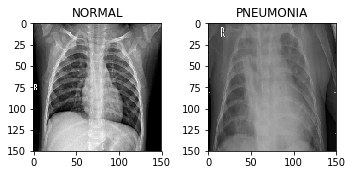

In [26]:
print(x_train.shape)

plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(y_train, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train_classes == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train_classes == 1)])

plt.tight_layout()

In [0]:
# DUMMY CELL for testing

def fullprint(*args, **kwargs):
    from pprint import pprint
    import sys
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold=sys.maxsize)
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)

In [0]:
# fullprint(y_train)

# Now move to doing the Neural NEtwork 

As we have shown that we are working with the original data and we have worked it into something usable in Tensorflow now it is time to take it from the very beginning and start with downloading the Inceptoion v3 model.





Next, we'll replace the orignal classification layer and build a new one:)

It will be composed of:

    Flatten transformation that reshapes the MaxPool output (4 x 4 x 512) into (1 x 1 x 8192)
    Fully Connected Dense layer with Softmax activation function with 2 outputs (1 x 1 x 2)

Softmax function normalizes input vector into a probability distribution that sums to 1.0



In [29]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

from keras.applications.inception_v3 import InceptionV3

K.clear_session()

NUM_CLASSES = 2

base_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(150, 150, 3))

x = base_model.output

# x = Flatten()(x)
# x = Dense(NUM_CLASSES, activation='softmax')(x)

# get layers and add average pooling layer
x = GlobalAveragePooling2D()(x)
#Add a dropout layer ?
# x = Dropout(0.4)(x)
# add fully-connected layer
x = Dense(512, activation='relu')(x)
# add output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
# Finalize the model
model = Model(inputs=base_model.input, outputs=predictions)


# model.summary()

Using TensorFlow backend.





87916544/87910968 [==============================] - 4s 0us/step


This network has over 14M trainable wegihts.

In [0]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

We would like to train only the most bottom classifier layers.

In [0]:
# # Dummy 
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
# for layer in model.layers[0:18]:
for layer in model.layers[0:311]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv2d_1, trainable: False
layer 2: batch_normalization_1, trainable: False
layer 3: activation_1, trainable: False
layer 4: conv2d_2, trainable: False
layer 5: batch_normalization_2, trainable: False
layer 6: activation_2, trainable: False
layer 7: conv2d_3, trainable: False
layer 8: batch_normalization_3, trainable: False
layer 9: activation_3, trainable: False
layer 10: max_pooling2d_1, trainable: False
layer 11: conv2d_4, trainable: False
layer 12: batch_normalization_4, trainable: False
layer 13: activation_4, trainable: False
layer 14: conv2d_5, trainable: False
layer 15: batch_normalization_5, trainable: False
layer 16: activation_5, trainable: False
layer 17: max_pooling2d_2, trainable: False
layer 18: conv2d_9, trainable: False
layer 19: batch_normalization_9, trainable: False
layer 20: activation_9, trainable: False
layer 21: conv2d_7, trainable: False
layer 22: conv2d_10, trainable: False
layer 23: batch_normalization_7, trainable:

In [33]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 2) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(2,) dtype=float32_ref>]

By locking the trainable layers we decrease ammount of trainable parameters to 16'384.



Here we use the "cross-entropy" loss function, which works well for learning probability distributions for classification.

See e.g.: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy


In [0]:
import numpy as np
import keras.backend as K
from itertools import product
from functools import partial

In [0]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


w_array = np.ones((2,2))
w_array[1,0] = 30 # penalizing FN
w_array[0,1] = 1 # penalizing FP

spec_loss = lambda y_true, y_pred: w_categorical_crossentropy(y_true, y_pred, weights=w_array)

In [36]:
# Create the loss function object using the wrapper function abov
optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',     #  loss=spec_loss,
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
# tensorboard = TensorBoard(
#     log_dir='./Graph', 
#     histogram_freq=0,  
#     write_graph=True
# )

# #####################

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

embedding_layer_names = set(layer.name
                            for layer in model.layers
                            if layer.name.startswith('dense_'))

tensorboard = TensorBoard(
    log_dir='./Graph',
    histogram_freq=1, 
    batch_size=32,
    write_graph=True, 
    write_grads=True, 
    write_images=True
)

The training set is un-balanaced. Let's calculate class weights


In [38]:
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [0]:
# # ############################### AA:  To get TensorBoard aempt 1 running in Colab   ################################################

# !pip install -q tf-nightly-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# import tensorflow as tf
# import datetime, os

# logs_base_dir = "./Graph"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

In [40]:
# ############################### AA:  To get TensorBoard aempt 2 running in Colab   ################################################

!pip install tensorboardcolab
from tensorboardcolab import *
tbc=TensorBoardColab()


Wait for 8 seconds...
TensorBoard link:
https://abf7707f.ngrok.io


In [41]:
# prepare a directory to store the model weights
os.makedirs('./model', exist_ok=True)

# history = model.fit(
#     x=x_train, y=y_train,
#     class_weight=classweight,
#     validation_split=0.3,
#     callbacks=[tensorboard],
#     shuffle=True,
#     batch_size=128,
#     epochs=60,
#     verbose=1
# )

history = model.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_data=(x_test, y_test),
    # callbacks=[tensorboard],
    callbacks=[TensorBoardColabCallback(tbc)],
    shuffle=True,
    batch_size=20,
    epochs=50,
    verbose=1
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5216 samples, validate on 624 samples


Epoch 1/50
5216/5216 [==============================] - 27s 5ms/step - loss: 0.3164 - acc: 0.8731 - val_loss: 1.0065 - val_acc: 0.7019
Epoch 2/50
5216/5216 [==============================] - 20s 4ms/step - loss: 0.2350 - acc: 0.9036 - val_loss: 1.3305 - val_acc: 0.6875
Epoch 3/50
5216/5216 [==============================] - 20s 4ms/step - loss: 0.1944 - acc: 0.9187 - val_loss: 1.6203 - val_acc: 0.6635
Epoch 4/50
5216/5216 [==============================] - 20s 4ms/step - loss: 0.2022 - acc: 0.9176 - val_loss: 1.4061 - val_acc: 0.6955
Epoch 5/50
5216/5216 [==============================] - 20s 4ms/step - loss: 0.2003 - acc: 0.9183 - val_loss: 1.3682 - val_acc: 0.6763
Epoch 6/50
5216/5216 [==============================] - 20s 4ms/step - loss: 0.1926 - acc: 0.9206 - val_loss: 2.3773 - val_acc: 0.6458
Epoch 7/50
5216/5216 [=========================

In [0]:
# # AA:  To get TensorBoard running in Colab

# !pip install -q tf-nightly-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# import tensorflow as tf
# import datetime, os

# logs_base_dir = "./Graph"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

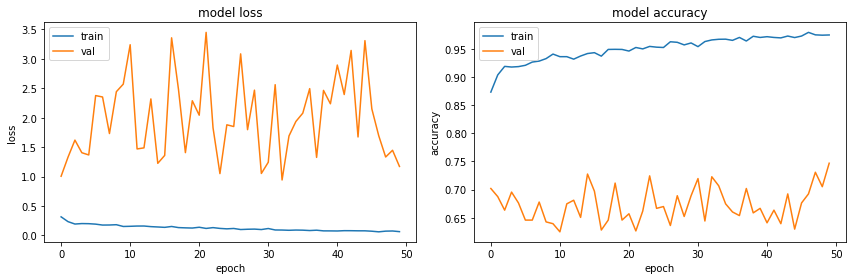

In [43]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

In [0]:
# dir(history.history)
# dir(history.history.keys)
# vars(history)
# from pprint import pprint; 
# pprint(vars(history)) 

# help(history)

# !pip3 install objbrowser
# !pip3 install six
# !pip3 install PySide
# from objbrowser import browse
# browse(history)

# pprint(vars(history))

Measure Loss and Accuracy on the test dataset

In [45]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 1.1730977247158687, Accuracy: 0.7467948717948718



## Looking at performance

AS you have seen in the previous lab regarding Malaria there are a lot of alterntative of plotting and calculating the performance. In this case lets us ethe Confusion Matrix.


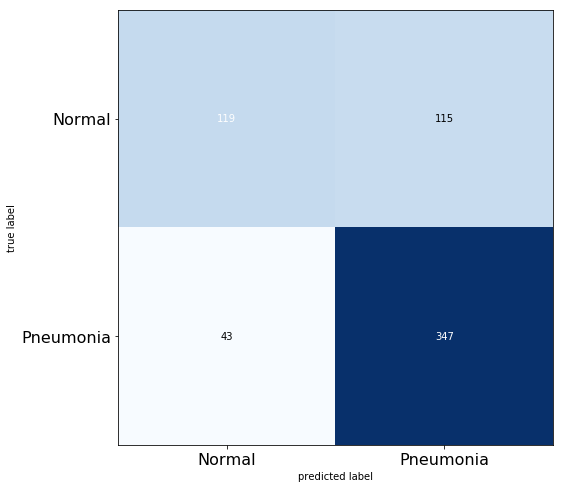

In [46]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

and ROC curve

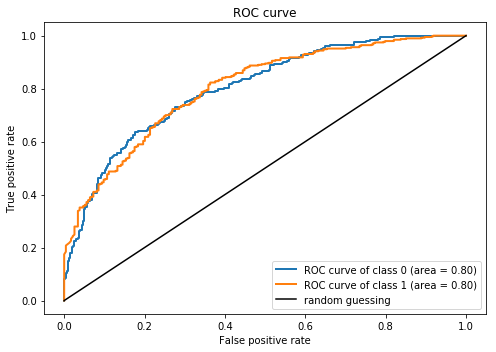

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

## Do the prediction with Pneumonia example

In [48]:
# Find the first, 2nd , 3rd occurance of the Pneumonia images
rtnIdx=0
elem = [0, 0, 0]

for rowId in range(len(y_test[:,0])):
    if y_test[rowId,0] == 1.0:
        # print("Found a 1.0 index at rowID: ", rowId)
        elem[rtnIdx] = rowId
        rtnIdx += 1
    if rtnIdx >2:
        break

print(elem)

# Now load the image data into a array 
# indextest=391
indextest=501
in_array = np.expand_dims(x_test[indextest,], axis=0)
print(in_array.shape)
predicted_1 = model.predict(in_array)
print(predicted_1)
print(y_test[indextest,])

[390, 391, 392]
(1, 150, 150, 3)
[[0.04534593 0.95465404]]
[1. 0.]


In [49]:
def find_and_test_prediction(classIdx, test_amt, xtest_array, ytest_array):
    #If class == 0, Find NORMAL,  if Class == 1,  find PNEUMONIA

    # Find the N number occurance 
    elemIdx=0
    elem = [0] * test_amt

    # Find 0->length of Array (array is sliced to focus on 1 column only)
    for rowId in range(len(ytest_array[:,classIdx])):
        if ytest_array[rowId,classIdx] == 1.0:
            # print("Debug:  for rowId: ", rowId, ", Found a 1.0 index.  To be insterted into output array at element Idx: ", elemIdx)
            elem[elemIdx] = rowId
            elemIdx += 1
        if elemIdx >= test_amt:
            break

    print(elem)

    # Now load test each image data element associated with that index  
    while len(elem) > 0:
        indextest = elem[0]
        #Expand the single test index to be the same format as 
        in_array = np.expand_dims(xtest_array[indextest,], axis=0)
        # Now run the prediction
        prediction = model.predict(in_array)
        print( "for Class Index: ",classIdx,"Found Index returned at: ",  indextest,  ".  Model Predicted output is :  ",  prediction, ".  Comparison reference output is : ",  y_test[indextest,], "\n")
        new_elem = np. delete(elem, 0)
        elem = new_elem

find_and_test_prediction(0, 10, x_test, y_test)
find_and_test_prediction(1, 10, x_test, y_test)

[390, 391, 392, 393, 394, 395, 396, 397, 398, 399]
for Class Index:  0 Found Index returned at:  390 .  Model Predicted output is :   [[0.16265759 0.83734244]] .  Comparison reference output is :  [1. 0.] 

for Class Index:  0 Found Index returned at:  391 .  Model Predicted output is :   [[0.9968991  0.00310092]] .  Comparison reference output is :  [1. 0.] 

for Class Index:  0 Found Index returned at:  392 .  Model Predicted output is :   [[0.99087405 0.00912593]] .  Comparison reference output is :  [1. 0.] 

for Class Index:  0 Found Index returned at:  393 .  Model Predicted output is :   [[0.87844706 0.12155295]] .  Comparison reference output is :  [1. 0.] 

for Class Index:  0 Found Index returned at:  394 .  Model Predicted output is :   [[0.18873367 0.8112663 ]] .  Comparison reference output is :  [1. 0.] 

for Class Index:  0 Found Index returned at:  395 .  Model Predicted output is :   [[0.8346973  0.16530271]] .  Comparison reference output is :  [1. 0.] 

for Class Ind